In [ ]:
!nvidia-smi

Tue Jan 26 02:13:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Build data

In [ ]:
import sys
import os
import time
from shutil import copyfile
import numpy as np
import json
import cv2
from pprint import pprint
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

### Prepare line images and annotations

In [ ]:
# !rm -r dense_rename
# !rm -r labeled_rename/
# !rm -r line_images
# !rm -r line_texts
# !rm -r ocr_training
# !rm -r page_images

In [ ]:
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/dense_renamed.zip /content/dense_renamed.zip
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/labeled_renamed.zip /content/labeled_renamed.zip

# !mkdir ocr_training/
# !mkdir ocr_training/page_images

# !unzip -qq /content/dense_renamed.zip
# !mv /content/rename/* /content/ocr_training/page_images/

# !unzip -qq /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/labeled_renamed.zip
# !mv /content/rename/* /content/ocr_training/page_images
len(os.listdir('ocr_training/page_images')), len(os.listdir('rename'))

mkdir: cannot create directory ‘ocr_training/’: File exists
mkdir: cannot create directory ‘ocr_training/page_images’: File exists


In [ ]:
def get_file_path_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(path + '/' + x)

    return img_paths

def get_file_name_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(x)

    return img_paths


def drop_extension(file_path):
    """
    Drop file extension of a file path.
    """
    return os.path.splitext(file_path)[0]

        
def get_all_text(path_list):
    """
    Combine text files into one .txt file.
    """
    all_texts = ""
    for file in path_list:
        all_texts += '\n' + open(file, 'r', encoding='utf8').read().strip()
    
    return all_texts.strip()


def combine_texts(path_list, out_file_path='all_text.txt'):
    all_texts = get_all_text(path_list)
    #save to out_file
    with open(out_file_path, 'w+', encoding='utf8') as f:
        f.write(all_texts)

In [ ]:
# path_list = get_file_path_by_type("line_annotations/", extensions=('.txt'))
# combine_texts(path_list)

In [ ]:
def bb_converter(coords: list):
    """
    Convert 8-coord bounding box to 4-coord bounding box.
    """
    return coords[0], coords[1], coords[4], coords[5]


def crop_rectangle(img, box=(None, None, None, None)):
    x1, y1, x2, y2 = box  # top_left_x, top_left_y, bot_right_x, bot_right_y
    return img[y1:y2, x1:x2, :]


def extract_element_from_page(img, json_annotations_object, extend_up_y=0.0, extend_down_y=0.0):
    cropped_imgs = []
    texts = []
    for idx, component in enumerate(json_annotations_object):
        x1, y1, x2, y2 = bb_converter(component["boundingBox"])

        y1 -= int(extend_up_y*(y2-y1))
        y2 += int(extend_down_y*(y2-y1))
        if x2-x1 < 32:
            x2 = x1 + y2-y1 + 3

        cropped_imgs.append(crop_rectangle(img, box=(x1, y1, x2, y2)))
        texts.append(component['text'])
        
    return cropped_imgs, texts
        

def save_elements(img_list, text_list, prefix, dst_img='line_images', dst_text='line_texts'):
    for idx, (img, s) in enumerate(zip(img_list, text_list)):
        img_path = dst_img + "/" + prefix + "_" + '{:0>3}'.format(str(idx)) + ".jpg"
        text_path = dst_text + "/" + prefix + ".txt"

        text_line = img_path + '\t' + s

        # write
        try:
            cv2.imwrite(img_path, img)
            with open(text_path, 'a', encoding='utf8') as f:
                f.write('\n'+text_line)
        except:
            pass

In [ ]:
from tqdm import tqdm

def extract_elements(src_folder, dst_img='line_images', dst_text='line_texts'):
    # make dst if not exist
    if not os.path.exists(dst_img):
        os.mkdir(dst_img)
    if not os.path.exists(dst_text):
        os.mkdir(dst_text)
    
    # get all img path in src_folder
    img_name_list = get_file_name_by_type(src_folder, extensions=('.jpg', '.png'))
    
    for idx, img_name in enumerate(img_name_list):
        if idx % 100 == 0:
            print(idx)
            
        page_name = drop_extension(img_name)
        json_path = src_folder + "/" + page_name + '_lines.json'
        img_path = src_folder + "/" + img_name
        
        page_layout = json.load(open(json_path, 'r', encoding='utf8'))
        page_img = cv2.imread(img_path)
        
        cur_page_line_imgs, cur_page_line_texts = extract_element_from_page(page_img, page_layout)  # list of line imgs

        save_elements(img_list=cur_page_line_imgs, 
                      text_list=cur_page_line_texts, 
                      prefix=page_name, 
                      dst_img=dst_img, 
                      dst_text=dst_text)

In [ ]:
# ocr_training as workspace
%cd /content/ocr_training

/content/ocr_training


In [ ]:
# # extract line and annotations
# extract_elements(src_folder='page_images', 
#                  dst_img='line_images', 
#                  dst_text='line_texts')

In [ ]:
# how many lines are there?
print("Image lines: %d"%(len(os.listdir('line_images'))))
# combine text files in all_line_annotations.txt
path_list = get_file_path_by_type("line_texts/", extensions=('.txt',))
combine_texts(path_list=path_list, out_file_path='all_line_annotations.txt')
# how many text line annotations?
all_annotations = open('all_line_annotations.txt', 'r', encoding='utf8').read().split('\n')
print("Text annotations: %d"%len(all_annotations))  # this must be equal to number of line images

Image lines: 258213
Text annotations: 258213


In [ ]:
with open('raw_anntations.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(all_annotations))

!cp raw_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/raw_annotations.txt

### Annotations preprocessing

In [ ]:
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/raw_annotations.txt raw_annotations.txt

In [ ]:
def check_valid(s, vocab):
  """
  Check if all chars in s belong to vocab. 
  """
  for char in str(s):
    if char not in vocab:
      return False
    else:
      continue
  return True

vocab = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
clean_annotations = []
for line in all_annotations:
  _, s = line.split('\t')
  if check_valid(s, vocab):
    clean_annotations.append(line)

print(len(all_annotations), len(clean_annotations))

258213 254564


In [ ]:
with open('clean_annotations.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(clean_annotations))

!cp clean_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/clean_annotations.txt

### Train, val, test split

In [ ]:
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/clean_annotations.txt /content/clean_annotations.txt 

In [ ]:
clean_annotations = open('clean_annotations.txt', 'r', encoding='utf8').read().strip().split('\n')
len(clean_annotations)

254564

In [ ]:
clean_annotations[:5]

['line_images/6851_000.jpg\t5. Thông tin và tài liệu truyền thông hưởng ứng Lễ kỷ niệm được giới thiệu',
 'line_images/6851_001.jpg\tvà đăng tải trên Trang thông tin điện tử Tổng cục Khí tượng Thủy văn tại các địa',
 'line_images/6851_002.jpg\tchỉ: http://vnmha.gov.vn và http://kttvqg.gov.vn.',
 'line_images/6851_003.jpg\tBộ Tài nguyên và Môi trường đề nghị Sở Tài nguyên và Môi trường các',
 'line_images/6851_004.jpg\ttỉnh, thành phố trực thuộc Trung ương thực hiện./.']

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(clean_annotations, test_size=0.15, shu)
train, valid = train_test_split(train, test_size=0.15)

print(len(train), len(valid), len(test))

183922 32457 38185


In [ ]:
# take a look
train[:10], valid[:10], test[:10]

(['line_images/6842_004.jpg\tV/v báo cáo kết quả thực hiện quy hoạch, kế',
  'line_images/4270_059.jpg\t11802',
  'line_images/4892_014.jpg\txử lý, giải quyết khiếu nại, tố cáo, kiến nghị, phản ánh; trực tiếp chỉ đạo làm rõ',
  'line_images/6399_032.jpg\t- Cổng thông tin điện tử BYT (để đăng tin);',
  'line_images/2304_028.jpg\tthuốc tập trung cấp địa phương, Trung tâm MSTTQG để thực hiện việc điều',
  'line_images/1589_035.jpg\t1. C/O mẫu D phải được làm bằng tiếng Anh, trên giấy màu trắng, khổ A4,',
  'line_images/2535_027.jpg\tvới lý do năm trước nhà thầu này không có vắc xin cung cấp. Khi tổ thẩm định',
  'line_images/3582_031.jpg\t- Tổ chức Hội nghị phổ biến Kế hoạch hành động Quốc gia về Chăm sóc',
  'line_images/2283_011.jpg\tquy định việc đấu thầu thuốc tại các cơ sở y tế công lập.',
  'line_images/3551_023.jpg\tkiểm kiểm nghiệm thuốc của Đoàn thanh tra'],
 ['line_images/6255_027.jpg\tđấu thầu tập trung cấp quốc gia do Trung tâm MSTTTQG thực hiện;',
  'line_images/4060_026.jpg\

In [ ]:
# save train, valid, test set
def save_list(saving_list, file='file.txt'):
  with open(file, 'w+', encoding='utf8') as f:
    f.write('\n'.join(saving_list))

# save_list(train, file='train_annotations.txt')
# save_list(valid, file='valid_annotations.txt')
# save_list(test, file='test_annotations.txt')

In [ ]:
# save to drive
!cp /content/train_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_annotations.txt 
!cp /content/valid_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_annotations.txt
!cp /content/test_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/test_annotations.txt


# Training
<p align="center">
<img src="https://raw.githubusercontent.com/pbcquoc/vietocr/master/image/vietocr.jpg" width="512" height="512">
</p>




In [ ]:
# copy training data from google drive to content for faster processing
! cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip ocr_training.zip
# unzip training data
! unzip -q ocr_training.zip
# ! mv /ocr_training/ /content/ocr_training/

^C
[ocr_training.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ocr_training.zip or
        ocr_training.zip.zip, and cannot find ocr_training.zip.ZIP, period.


In [ ]:
# load annotations from drive
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_train_annotations.txt /content/ocr_training/train_annotations.txt
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_valid_annotations.txt /content/ocr_training/valid_annotations.txt
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_test_annotations.txt /content/ocr_training/test_annotations.txt
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_clean_annotations.txt  /content/ocr_training/clean_annotations.txt

cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_train_annotations.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_valid_annotations.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_test_annotations.txt': No such file or directory


In [ ]:
# ! zip -r ocr_training.zip ocr_training/

In [ ]:
# ! mv ocr_training.zip /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip

Duplicate annotations for more data (use augment)

In [ ]:
with open('ocr_training/train_annotations.txt', 'r', encoding='utf8') as f:
  train = f.read().split('\n')

In [ ]:
import random

def dup_list(input_list, dup_times, shuffle=False):
  output = []
  for _ in range(dup_times):
    output.extend(input_list)
  if shuffle:
    random.shuffle(output)
  return output

train_1m = dup_list(input_list=train, dup_times=6, shuffle=True)  # 184k*6~1.1 mil
len(train_1m)

1103532

In [ ]:
with open('train_annotations_1m.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(train_1m))
!cp train_annotations_1m.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_annotations_1m.txt

# Reload Data

In [ ]:
!cp /content/drive/MyDrive/OmegaOCR/data/ocr/ocr_training.zip ocr_training.zip
!unzip -q ocr_training.zip

!cp -r /content/drive/MyDrive/OmegaOCR/data/ocr/valid_hw valid_hw

In [ ]:
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/strongai_clean_annotations.txt ocr_training/clean_annotations.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/strongai_train_annotations_1m.txt ocr_training/train_annotations_1m.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/strongai_train_annotations.txt ocr_training/train_annotations.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/strongai_valid_annotations.txt ocr_training/valid_annotations.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/strongai_test_annotations.txt ocr_training/test_annotations.txt

In [ ]:
# !cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/real_shot_lines.zip real_shot_lines.zip 
# !unzip -q real_shot_lines.zip

In [ ]:
# !mv real_shot_lines/*.jpg ocr_training/line_images/

In [ ]:
# !cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/configs configs
# !cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/weights weights

In [ ]:
# !zip -r -q ocr_training.zip ocr_training/
# !cp ocr_training.zip /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip

In [ ]:
# length of training set, to decide iterations
len(open('ocr_training/train_annotations.txt', 'r', encoding='utf8').read().split('\n'))

205395

# Train model



1.   Load your config
2.   Train model using your dataset above



In [ ]:
! pip install --quiet vietocr==0.3.5

     |████████████████████████████████| 61kB 3.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 286kB 8.7MB/s 
     |████████████████████████████████| 952kB 21.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [ ]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer
from vietocr.tool.predictor import Predictor

# Change the config 

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [ ]:
model_name = 'vgg_seq2seq'
config = Cfg.load_config_from_name(model_name)

config['vocab'] = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

dataset_params = {
    'name':'hw',
    'data_root':'./ocr_training/',
    'train_annotation':'train_annotations_1m.txt',
    'valid_annotation':'valid_annotations.txt',
    'image_max_width': 512,
}

params = {
        'batch_size': 64,
         'print_every': 200,
         'valid_every': 4000,
          'iters': 32000,  # 1022k/64 * 2 epochs
          'checkpoint':'./checkpoint/' + model_name + '_checkpoint.pth',    
          'export':'./weights/' + model_name + '.pth',
          'metrics': 20000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['device'] = 'cuda:0'
config['aug']['image_aug'] = True
config['aug']['masked_language_model'] = True
config['predictor']['beamsearch'] = False

you can change any of these params in this full list below

In [ ]:
config

{'aug': {'image_aug': True, 'masked_language_model': True},
 'backbone': 'vgg19_bn',
 'cnn': {'hidden': 256,
  'ks': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]],
  'ss': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]]},
 'dataloader': {'num_workers': 3, 'pin_memory': True},
 'dataset': {'data_root': './ocr_training/',
  'image_height': 32,
  'image_max_width': 512,
  'image_min_width': 32,
  'name': 'hw',
  'train_annotation': 'train_annotations_1m.txt',
  'valid_annotation': 'valid_annotations.txt'},
 'device': 'cuda:0',
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'predictor': {'beamsearch': False},
 'pretrain': {'cached': '/tmp/tranformerorc.pth',
  'id_or_url': '1nTKlEog9YFK74kPyX0qLwCWi60_YHHk4',
  'md5': 'efcabaa6d3adfca8e52bda2fd7d2ee04'},
 'quiet': False,
 'seq_modeling': 'seq2seq',
 'trainer': {'batch_size': 64,
  'checkpoint': './checkpoint/vgg_seq2seq_checkpoint.pth',
  'export': './weights/vgg_seq2seq.pth',
  'iters': 32000,
  'log': './train.log',
  'metrics': 20000,
  'print

You should train model from our pretrained 

In [ ]:
trainer = Trainer(config, pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Cached Downloading: /tmp/tranformerorc.pth
Downloading...
From: https://drive.google.com/uc?id=1nTKlEog9YFK74kPyX0qLwCWi60_YHHk4
To: /root/.cache/gdown/tmpm6ibnw_5/dl
89.6MB [00:01, 47.6MB/s]


Computing MD5: /tmp/tranformerorc.pth
MD5 matches: /tmp/tranformerorc.pth


Create train_hw: 100%|███████████████████████████████████| 1026975/1026975 [21:00<00:00, 814.67it/s]


Remove 3175 invalid images
Created dataset with 1023799 samples


train_hw build cluster: 100%|██████████████████████████| 1023799/1023799 [00:18<00:00, 55924.77it/s]

valid_hw exists. Remove folder if you want to create new dataset



valid_hw build cluster: 100%|██████████████████████████████| 32456/32456 [00:00<00:00, 45701.06it/s]


In [ ]:
# !rm -r train_hw

In [ ]:
# !cp -r train_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_hw
# !cp -r valid_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_hw

Save model configuration for inference, load_config_from_file

In [ ]:
# trainer.config.save('transformer_config.yml')

Visualize your dataset to check data augmentation is appropriate

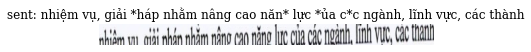

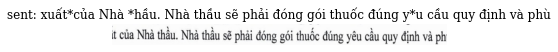

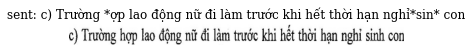

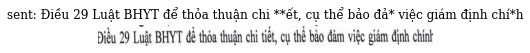

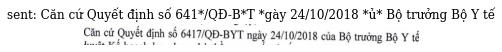

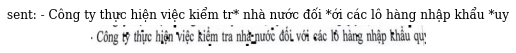

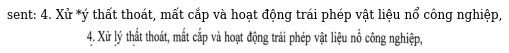

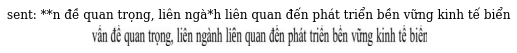

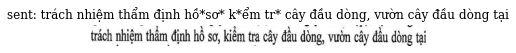

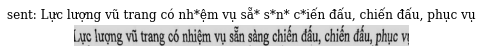

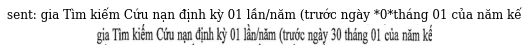

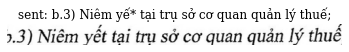

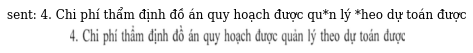

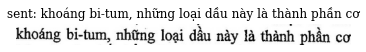

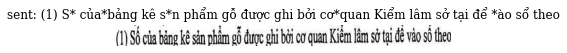

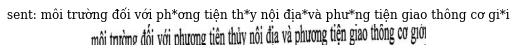

In [ ]:
trainer.visualize_dataset()

Train now

In [ ]:
import time
tic = time.time()
trainer.train()
print('\nTotal training time: %.2fs'%(time.time()-tic))

iter: 000200 - train loss: 0.766 - lr: 4.92e-05 - load time: 1.13 - gpu time: 149.70
iter: 000400 - train loss: 0.721 - lr: 7.66e-05 - load time: 0.06 - gpu time: 145.24
iter: 000600 - train loss: 0.716 - lr: 1.21e-04 - load time: 0.04 - gpu time: 154.33
iter: 000800 - train loss: 0.689 - lr: 1.81e-04 - load time: 0.04 - gpu time: 153.92
iter: 001000 - train loss: 0.686 - lr: 2.53e-04 - load time: 0.06 - gpu time: 150.05
iter: 001200 - train loss: 0.690 - lr: 3.36e-04 - load time: 0.05 - gpu time: 152.92
iter: 001400 - train loss: 0.674 - lr: 4.27e-04 - load time: 0.06 - gpu time: 142.26
iter: 001600 - train loss: 0.685 - lr: 5.20e-04 - load time: 0.06 - gpu time: 144.16
iter: 001800 - train loss: 0.673 - lr: 6.14e-04 - load time: 0.05 - gpu time: 153.38
iter: 002000 - train loss: 0.674 - lr: 7.04e-04 - load time: 0.04 - gpu time: 145.64
iter: 002200 - train loss: 0.689 - lr: 7.87e-04 - load time: 0.06 - gpu time: 150.74
iter: 002400 - train loss: 0.682 - lr: 8.60e-04 - load time: 0.05

/usr/local/lib/python3.6/dist-packages/vietocr/tool/translate.py:115: RuntimeWarning: invalid value encountered in true_divide
  char_probs = np.sum(char_probs, axis=-1)/(char_probs>0).sum(-1)


iter: 004000 - valid loss: 0.656 - acc full seq: 0.8173 - acc per char: 0.9566
iter: 004200 - train loss: 0.669 - lr: 9.97e-04 - load time: 0.05 - gpu time: 154.44
iter: 004400 - train loss: 0.678 - lr: 9.96e-04 - load time: 0.05 - gpu time: 151.65
iter: 004600 - train loss: 0.667 - lr: 9.94e-04 - load time: 0.05 - gpu time: 148.87
iter: 004800 - train loss: 0.674 - lr: 9.92e-04 - load time: 0.05 - gpu time: 154.70
iter: 005000 - train loss: 0.681 - lr: 9.90e-04 - load time: 0.04 - gpu time: 156.94
iter: 005200 - train loss: 0.666 - lr: 9.88e-04 - load time: 0.06 - gpu time: 146.71
iter: 005400 - train loss: 0.664 - lr: 9.86e-04 - load time: 0.06 - gpu time: 148.65
iter: 005600 - train loss: 0.678 - lr: 9.83e-04 - load time: 0.06 - gpu time: 159.61
iter: 005800 - train loss: 0.661 - lr: 9.80e-04 - load time: 0.04 - gpu time: 150.58
iter: 006000 - train loss: 0.687 - lr: 9.77e-04 - load time: 0.07 - gpu time: 157.24
iter: 006200 - train loss: 0.683 - lr: 9.73e-04 - load time: 0.05 - gpu

In [ ]:
!cp -r weights/vgg_seq2seq.pth /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/weights/vgg_seq2seq_real_shot_1m_32000.pth

Visualize prediction from our trained model


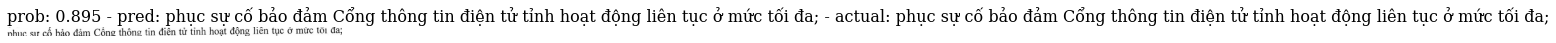

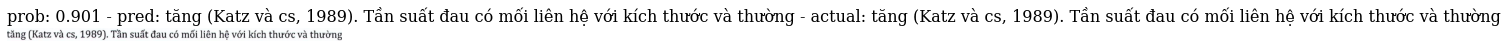

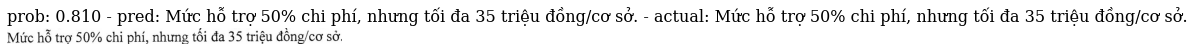

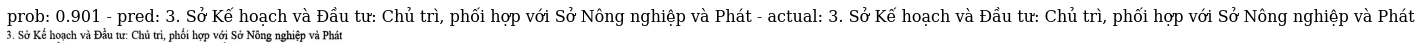

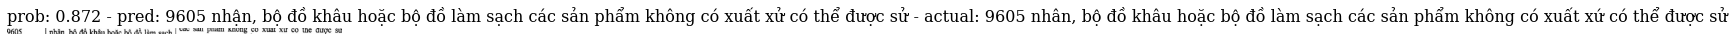

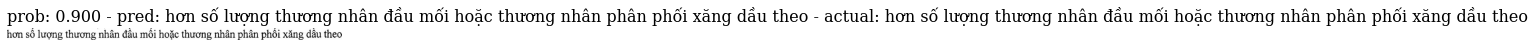

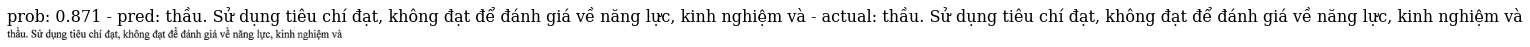

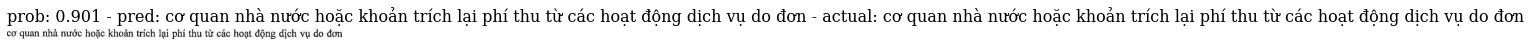

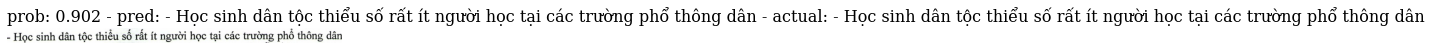

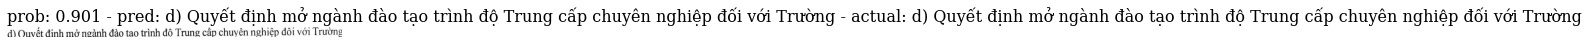

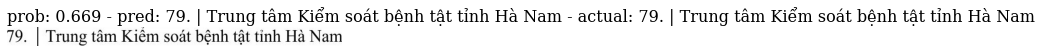

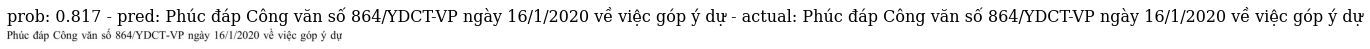

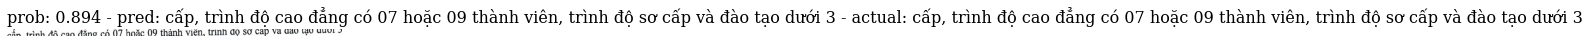

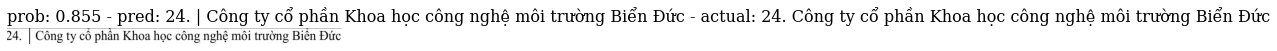

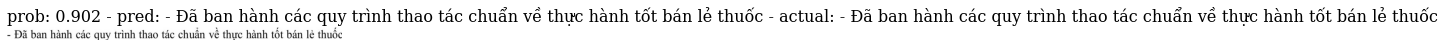

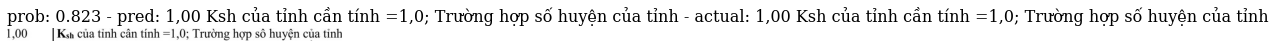

In [ ]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [ ]:
trainer.precision()

(0.9094274109014675, 0.9810388)

In [ ]:
# !cp -r configs /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/configs
# !cp -r valid_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_hw
# !cp -r train_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_hw

# Evaluate the model

In [ ]:
# reload the model
!cp -r /content/drive/MyDrive/OmegaOCR/data/ocr/weights/vgg_seq2seq_real_shot_1m_32000.pth weights/vgg_seq2seq.pth

In [ ]:
# config = Cfg.load_config_from_name('vgg_seq2seq')
model_name = 'vgg_seq2seq'
config = Cfg.load_config_from_name(model_name)

config['weights'] = './weights/' + model_name + '.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False

In [ ]:
detector = Predictor(config)

In [ ]:
def read_lines(file_path):
  return open(file_path, 'r', encoding='utf8').read().strip().split('\n')

In [ ]:
def SER(hypo: str, ref:str):
    """
    Inputs:
      - hypo: predicted string from ocr
      - ref: correct string
    Returns (float) Sequence Error Rate between 2 strings
    """
    if hypo == ref:
      return 1
    else:
      return 0

def WER(hypo:str, ref:str):
    """
    Inputs:
        - hypo: predicted string from ocr
        - ref: correct string
    Returns (float) Word Error Rate between 2 strings
    """
    # Splits str to list of words 
    hypo = hypo.split()
    ref = ref.split()

    h = len(hypo)
    r = len(ref)
    D = np.zeros((r+1, h+1))
    D[0,:] = np.arange(h+1)
    D[:,0] = np.arange(r+1)
    for i in range(1,r+1):
        for j in range(1,h+1):
            if ref[i-1] == hypo[j-1]:
                D[i,j] = D[i-1,j-1]
            else:
                D[i,j] = min(D[i-1,j-1], D[i-1,j], D[i,j-1]) + 1
    return D[r,h]/r

def CER(hypo:str, ref:str):
    """
    Inputs:
        - hypo: predicted string from ocr
        - ref: correct string
    Returns (float) Character Error Rate between 2 strings
    """
    # No need to split strings to list of words.
    # hypo = hypo.split()
    # ref = ref.split()

    h = len(hypo)
    r = len(ref)
    D = np.zeros((r+1, h+1))
    D[0,:] = np.arange(h+1)
    D[:,0] = np.arange(r+1)
    for i in range(1,r+1):
        for j in range(1,h+1):
            if ref[i-1] == hypo[j-1]:
                D[i,j] = D[i-1,j-1]
            else:
                D[i,j] = min(D[i-1,j-1], D[i-1,j], D[i,j-1]) + 1
    return D[r,h]/r

In [ ]:
# save train, valid, test set
def save_list(saving_list, file='file.txt'):
  with open(file, 'w+', encoding='utf8') as f:
    f.write('\n'.join(saving_list))

In [ ]:
eval_list = [
  # 'all_text_shot_corrected.txt', 'train_annotations.txt', 'valid_annotations.txt', 
            'test_annotations.txt',]
def run_test(eval_list):
  total_wer = 0.0
  total_cer = 0.0
  total_ser = 0.0

  src = '/content/ocr_training/'
  for f in eval_list:
      print(f)
      lines = read_lines(src + '/' + f)
      predict_and_ground_truth = []
      # from tqdm import tqdm
      # lines = lines[:30000] # Take the first 
      for idx, line in enumerate(lines):
        try:
          file, content = line.split('\t')
          file = os.path.join(src, file)
          img = Image.open(file)
          s = detector.predict(img)
        except Exception as e:
          print(idx, line, e)
          continue

        total_wer += WER(s, content)
        total_cer += CER(s, content)
        total_ser += SER(s, content)
        predict_and_ground_truth.append(f"Pred: {s}\tTruth: {content}")

      print('Average SER: ', total_ser/len(lines))
      print('Average WER: ', total_wer/len(lines))
      print('Average CER: ', total_cer/len(lines))    

      save_list(predict_and_ground_truth, file= f + '_results.txt')

run_test(eval_list)

test_annotations.txt
45 line_images/6378_011.jpg	CONG [Errno 2] No such file or directory: '/content/ocr_training/line_images/6378_011.jpg'
145 line_images/2931_005.jpg	cáo đề nghị thanh toán ngày 05/7/2018, thực hiện Biên bản thanh, quyết toán (Mẫu [Errno 2] No such file or directory: '/content/ocr_training/line_images/2931_005.jpg'
181 line_images/2452_021.jpg	suy tim hoặc nhồi máu cơ tim với phân số tống máu thất trái dưới 0,40 (40%) không [Errno 2] No such file or directory: '/content/ocr_training/line_images/2452_021.jpg'
881 line_images/6570_020.jpg	CONG HO [Errno 2] No such file or directory: '/content/ocr_training/line_images/6570_020.jpg'
1588 line_images/6243_007.jpg	OHTA [Errno 2] No such file or directory: '/content/ocr_training/line_images/6243_007.jpg'
1609 line_images/3381_034.jpg	rút ra khỏi Danh mục thuốc có chứng minh tương đương sinh học sau khi đã trúng [Errno 2] No such file or directory: '/content/ocr_training/line_images/3381_034.jpg'
1739 line_images/6097_010.jp

In [ ]:
!cp test_annotations.txt_results.txt /content/drive/MyDrive/OmegaOCR/data/ocr/run_test/vgg_seq2seq_1m_32000/test_annotations_results.txt

In [ ]:
# sample train set for visual evaluate
import random
sample_train = random.choices(read_lines('ocr_training/train_annotations.txt'), k=25000)
sample_train[:10]

save_list(sample_train, 'ocr_training/sample_train_30k.txt')

In [ ]:
eval_list = [
  # 'all_text_shot_corrected.txt', 
  # 'train_annotations.txt', 
  # 'valid_annotations.txt', 
  # 'test_annotations.txt',
  'sample_train_30k.txt'
  ]
run_test(eval_list)

sample_train_30k.txt
164 line_images/2499_006.jpg	+ Tác giả là người Việt Nam xếp thứ tự ABC theo tên nhưng vẫn giữ nguyên [Errno 2] No such file or directory: '/content/ocr_training/line_images/2499_006.jpg'
287 line_images/3015_003.jpg	Sau khi sử dụng tay khoan điều trị trong miệng NB các tay khoan nha khoa [Errno 2] No such file or directory: '/content/ocr_training/line_images/3015_003.jpg'
617 line_images/3169_029.jpg	hóa; Điện tim- Điện não. Tầng 3: Tiểu phẫu; phòng lưu bệnh nhân; TMH; Nội [Errno 2] No such file or directory: '/content/ocr_training/line_images/3169_029.jpg'
852 line_images/3169_001.jpg	Tại thời điểm thanh tra Bệnh viện không quảng cáo trên mạng Internet và các [Errno 2] No such file or directory: '/content/ocr_training/line_images/3169_001.jpg'
858 line_images/6507_044.jpg	Y TE [Errno 2] No such file or directory: '/content/ocr_training/line_images/6507_044.jpg'
944 line_images/6051_016.jpg	GIÁO [Errno 2] No such file or directory: '/content/ocr_training/line_imag

In [ ]:
!cp sample_train_30k.txt_results.txt /content/drive/MyDrive/OmegaOCR/data/ocr/run_test/vgg_seq2seq_1m_32000/sample_train_30k_results.txt

In [ ]:
print('done')

# Inference on real data

In [ ]:
# load real data from drive
! cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/real_shot_lines.zip real_shot_lines.zip
! unzip -q real_shot_lines.zip

In [ ]:
# config = Cfg.load_config_from_name('vgg_seq2seq')
config = Cfg.load_config_from_name(model_name)

Change weights to your weights or using default weights from our pretrained model. Path can be url or local file

In [ ]:
config['weights'] = './weights/' + model_name + '.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False

In [ ]:
detector = Predictor(config)

In [ ]:
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_file_path_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(path + '/' + x)

    return img_paths

img_path = get_file_path_by_type("real_shot_lines", extensions=('.jpg',))

predicts = []
times = []
for i in img_path:
  try:
    img = Image.open(open(i, 'rb'))
    tic = time.time()
    pred_sent, prob = detector.predict(img, return_prob=True)
    times.append(time.time() - tic)
    
    plt.figure()
    plt.imshow(img)
    plt.title('prob: {:.3f} - pred: {}'.format(prob, pred_sent), loc='left')
    plt.axis('off')
    plt.show()
    
  except:
    print(1)

# plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from pprint import pprint
import numpy as np

print("Average time prediction: %.3fs"%(np.mean(times)))

Average time prediction: 0.062s


# Summary

**vgg_seq2seq:**
- 6000 steps
- train set: 1 milion lines, augmented from 200k lines
- training times: ~7h
- Tesla V100
- batch size 64
- masked language model: 1 số token (char or word) trong training sequence bị dấu đi (dấu *)
- train set precision:  
Average SER:  0.08896  
Average WER:  0.021354601899778194  
Average CER:  0.01403317786523853  
- valid set precision: (0.9094274109014675, 0.9810388)
- test set precision:   
Average SER:  0.10607183246889984  
Average WER:  0.028031233064657365  
Average CER:  0.0170765804054051  

- Average inference time: 0.062s

In [3]:
1-0.9810

0.019000000000000017